In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py
import os
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb

from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
DATA_DIR ='../data'
RAW_DIR =  os.path.join(DATA_DIR, 'raw/')
EXTERNAL_DIR = os.path.join(DATA_DIR, 'external/')
TRAIN_DATA = os.path.join(RAW_DIR, 'train.csv')
STOPWORDS_DIR = os.path.join(EXTERNAL_DIR, 'stopwords.txt')

In [5]:
from src.features.build_features import get_stopwords

In [6]:
df = pd.read_csv(TRAIN_DATA, delimiter='|')
df

,Pregunta,Intencion
0,como puedo trabajar en santander rio,Cat_102
1,pagar tarjeta visa querer reintegro,Cat_350
2,pagar tarjeta naranja sistema,Cat_132
3,no se debitó la primera cuota del plan de bien...,Cat_129
4,abonar tarjeta credito,Cat_342
...,...,...
20099,el monto del prestamo depende de los ingresos???,Cat_251
20100,quiero cancelar una compra puntual el cuotas,Cat_339
20101,necesito pagar deuda,Cat_192
20102,teniendo otro hipotecario es posible aplicar p...,Cat_218


In [7]:
STOPWORDS = get_stopwords(STOPWORDS_DIR)

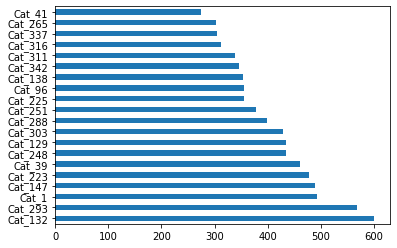

In [8]:
df.Intencion.value_counts().nlargest(20).plot.barh()

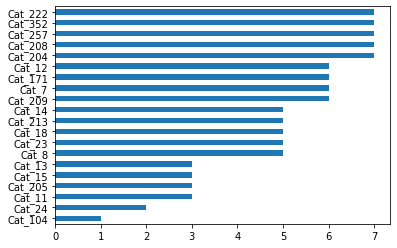

In [9]:
df.Intencion.value_counts().nsmallest(20).plot.barh()

In [10]:
df = df[(df.Intencion != 'Cat_104')]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.Pregunta, df.Intencion, test_size=0.3, random_state = 42, stratify=df.Intencion)#stratify=df.Intencion)

In [12]:
df.shape, df.Intencion.nunique()

((20103, 2), 351)

In [31]:
preprocess =  Pipeline([
#     ('vect', CountVectorizer(stop_words=STOPWORDS, ngram_range=(1,1))),
#     ('tfidf', TfidfTransformer()),
    ('tfidf', TfidfVectorizer(stop_words=STOPWORDS, max_features=1000)),
#     ('scaler', RobustScaler()),
#     ('compress', TruncatedSVD(100))
])

In [32]:
preprocess.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=1000,
                                 stop_words=['0', '1', '2', '3', '4', '5', '6',
                                             '7', '8', '9', 'a', 'actualmente',
                                             'acuerdo', 'adelante', 'ademas',
                                             'adrede', 'afirmo', 'agrego',
                                             'ahi', 'ahora', 'al', 'algo',
                                             'algun', 'alguna', 'algunas',
                                             'alguno', 'algunos', 'alli',
                                             'alrededor', 'ambos', ...]))])

In [33]:
def fit_model(model, X, y, fit_params={}):
    text_features = preprocess.transform(X)
    model.fit(text_features, y, **fit_params)
    return model

In [34]:
def get_preds(model, preprocess, X):
    text_features = preprocess.transform(X)
    return model.predict(text_features)

In [35]:
def metric(y_true, train_data):
    y_pred = train_data.reshape(y_true.shape[0], -1).argmax(axis=1)
    return 'BALANCED_ACCURACY', balanced_accuracy_score(y_true.reshape(-1,1), y_pred.reshape(-1,1)), True

In [36]:
def metric_xgb(preds, train):
    ytrue = train.get_label()
    ypred = preds.argmax(axis=1)
    return 'BALANCED_ACCURACY', -balanced_accuracy_score(ytrue, ypred)

In [37]:
def get_metrics(model, preprocess, X_train, y_train, X_test, y_test):
    
    y_pred = get_preds(model, preprocess, X_train)
    train_metric = balanced_accuracy_score(y_train, y_pred)
    print('El valor de Accuracy en Train es de: {}'.format(train_metric))
    
    y_pred = get_preds(model, preprocess, X_test)
    test_metric = balanced_accuracy_score(y_test, y_pred)
    print('El valor de Accuracy en Test es de: {}'.format(test_metric))
    return train_metric, test_metric

In [41]:
metrics = []
step = 100

for i in range(5):
    print("Epoch: ",i)
    warm_start = i!=0
    rf = RandomForestClassifier(n_estimators=step, warm_start=warm_start, n_jobs=3)
    fit_model(rf, X_train, y_train)
    metrics.append(get_metrics(rf, preprocess, X_train, y_train, X_test, y_test))

In [46]:
metrics = []
step = 100

for i in range(5):
    print("Epoch: ",i)
    warm_start = i!=0
    rf = MLPClassifier([1000,1000,250,250], warm_start=warm_start, early_stopping=True, max_iter=100)
    fit_model(rf, X_train, y_train)
    metrics.append(get_metrics(rf, preprocess, X_train, y_train, X_test, y_test))

Epoch:  0


/home/jloscalzo/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


El valor de Accuracy en Train es de: 0.7603339002392758
El valor de Accuracy en Test es de: 0.40540983685507
Epoch:  1
El valor de Accuracy en Train es de: 0.8171137921962595
El valor de Accuracy en Test es de: 0.4135614143039293
Epoch:  2
El valor de Accuracy en Train es de: 0.8250764960289338
El valor de Accuracy en Test es de: 0.42510636458223694
Epoch:  3
El valor de Accuracy en Train es de: 0.822005204853663
El valor de Accuracy en Test es de: 0.43476677614210063
Epoch:  4
El valor de Accuracy en Train es de: 0.8310422285017566
El valor de Accuracy en Test es de: 0.4254811730163637


In [1]:
# xg = xgb.XGBClassifier(n_estimators=50, learning_rate=0.5, verbose=2)
# fit_params = {
#     "eval_set":[(preprocess.transform(X_train), y_train), (preprocess.transform(X_test), y_test)], 
#     "eval_metric": metric_xgb,
#     "early_stopping_rounds":10
# }
# fit_model(xg, X_train, y_train, fit_params)


In [ ]:
# clf = SVC(C=2)
# fit_model(clf, X_train, y_train)

In [ ]:
# params = {
#     "num_leaves": 31,
#     "learning_rate": 0.05,
#     "n_estimators": 100,
#     "silent": False
# }

# lg = lgb.LGBMClassifier(**params, random_state=42)
# fit_model(lg, X_train, y_train, fit_params={
#     "verbose": True,
#     "eval_set":[(preprocess.transform(X_train), y_train), (preprocess.transform(X_test), y_test)], 
#     "eval_names":["train", "test"], 
#     "eval_metric":metric
# })

In [29]:
get_metrics(rf, preprocess,X_train, y_train, X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


El valor de Accuracy en Train es de: 0.9581639319481953


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


El valor de Accuracy en Test es de: 0.2762362528760578


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished


In [13]:
# print(classification_report(y_test, pipeline.predict(X_test)))